In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import image
from matplotlib.gridspec import GridSpec
import string
from tqdm import tqdm 
import os
import pandas as pd
import itertools

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests

from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import gc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


outdir = '/mnt/home/awakhloo/ceph/reprod_population_geom_opt_coding/results'
figdir = '/mnt/home/awakhloo/ceph/reprod_population_geom_opt_coding/figures/pngs'

In [19]:
path = outdir + '/majaj_res.npy' 
res = np.load(path, allow_pickle=True).item() 
all_cls = res['all_classes']
glob_p = res['global_pooling'] 
proj88 = res['proj_88']

emppixmed, svcpixmed, thepixmed, geompixmed = all_cls[0]
empv4med, svcv4med, thev4med, geomv4med = all_cls[1]
empITmed, svcITmed, theITmed, geomITmed = all_cls[2] 

pemppixmed, psvcpixmed, pthepixmed, pgeompixmed = glob_p[0]
pempv4med, psvcv4med, pthev4med, pgeomv4med = glob_p[1]
pempITmed, psvcITmed, ptheITmed, pgeomITmed = glob_p[2]

emppixmedproj, svcpixmedproj, thepixmedproj, geompixmedproj = proj88[0]
empITmedproj, svcITmedproj, theITmedproj, geomITmedproj = proj88[1]

# remap geom indices back to original order of dim, corr, ssf, snf expected in this notebook
# (utils.get_geometry returns dim, corr, snf, ssf, ... a few extra)
geom_index_remap = [0, 1, 3, 2]
geompixmed = geompixmed[..., geom_index_remap]
geomv4med = geomv4med[..., geom_index_remap]
geomITmed = geomITmed[..., geom_index_remap]
pgeompixmed = tuple(np.array(pgeompixmed)[geom_index_remap])
pgeomv4med = tuple(np.array(pgeomv4med)[geom_index_remap])
pgeomITmed = tuple(np.array(pgeomITmed)[geom_index_remap])
geompixmedproj = geompixmedproj[..., geom_index_remap]
geomITmedproj = geomITmedproj[..., geom_index_remap]

Ps = np.logspace(1, np.log10(200),10, dtype=int) 
Psg = np.logspace(1, 3, 15,dtype=int)

# plot all 

In [20]:
def plot_res(ax, emppix, thepix, empv4, thev4, empIT, theIT, fn, vr, colors):
    nclass = empv4.shape[0]
    print(nclass)
    ax.errorbar(Ps, emppix.mean((1,0)), yerr=emppix.mean(1).std(0)/np.sqrt(nclass), 
                color=colors[0], **emp_kwargs)
    ax.plot(Ps, thepix.mean(0),label='pixel',ls='-',color=colors[1])

    ax.errorbar(Ps, empv4.mean((1,0)), yerr=empv4.mean(1).std(0)/np.sqrt(nclass), color=colors[2], **emp_kwargs)
    ax.plot(Ps, thev4.mean(0),label='V4',ls='-',color=colors[3])

    ax.errorbar(Ps, empIT.mean((1,0)), yerr=empIT.mean(1).std(0)/np.sqrt(nclass), color=colors[4],**emp_kwargs)
    ax.plot(Ps, theIT.mean(0),label='IT',ls='-',color=colors[5])

    ax.set_xlabel(r"training samples ($p$)", fontsize=fn)
    ax.set_ylabel("$E_g$", fontsize=fn)
    ax.set_title("multi-task generalization error ($E_g$)", fontsize=fn)
    

    ax.set_xscale('log')
    
def plot_geom(axs, geoms, colors, fn, vr, offset=0., width=1., alpha=0.5): 
    ''' 
    assume shape nclass x n_area x n_metrics
    '''
    names = ['dimension', 
             'neural-latent correlation', 
             'signal-signal factorization', 'signal-noise factorization'] 
    xticks = ['pixels', 'V4', 'IT']
    # for i, ax in enumerate(axs): 
    #     ax.plot(xticks, geoms[i],color=colors[i], label=vr)
    #     ax.set_title(names[i], fontsize=fn)
    #     ax.set_xticklabels(xticks, fontsize=fn*3/4)
    x = np.arange(len(xticks))
    nclass = geoms.shape[0]
    print('nclass = ', nclass) 
    for i, ax in enumerate(axs): 
        print(geoms[...,i].mean(0))
        bars = ax.bar(x+offset, geoms[...,i].mean(0), 
                      label=vr, width=width,
                      # yerr=geoms[...,i].std(0)/np.sqrt(nclass),
                     alpha=alpha)
        # plot the indiv points 
        for cc in range(nclass): 
            ax.scatter(x+offset, geoms[cc, ..., i], color=colors)
            ax.plot(x+offset, geoms[cc, ..., i], color='grey', ls='-', alpha=0.3)

        ax.set_title(names[i], fontsize=fn)
        ax.set_xticks(x, xticks, fontsize=fn*3/4)
        for k, b in enumerate(bars):
            b.set_color(colors[k])
        



8
nclass =  8
[11.93367487  5.47019764 10.83208275]
[0.00625762 0.01696775 0.02018007]
[0.5811364  0.31796601 0.37787291]
[0.10239851 0.09202491 0.25787416]


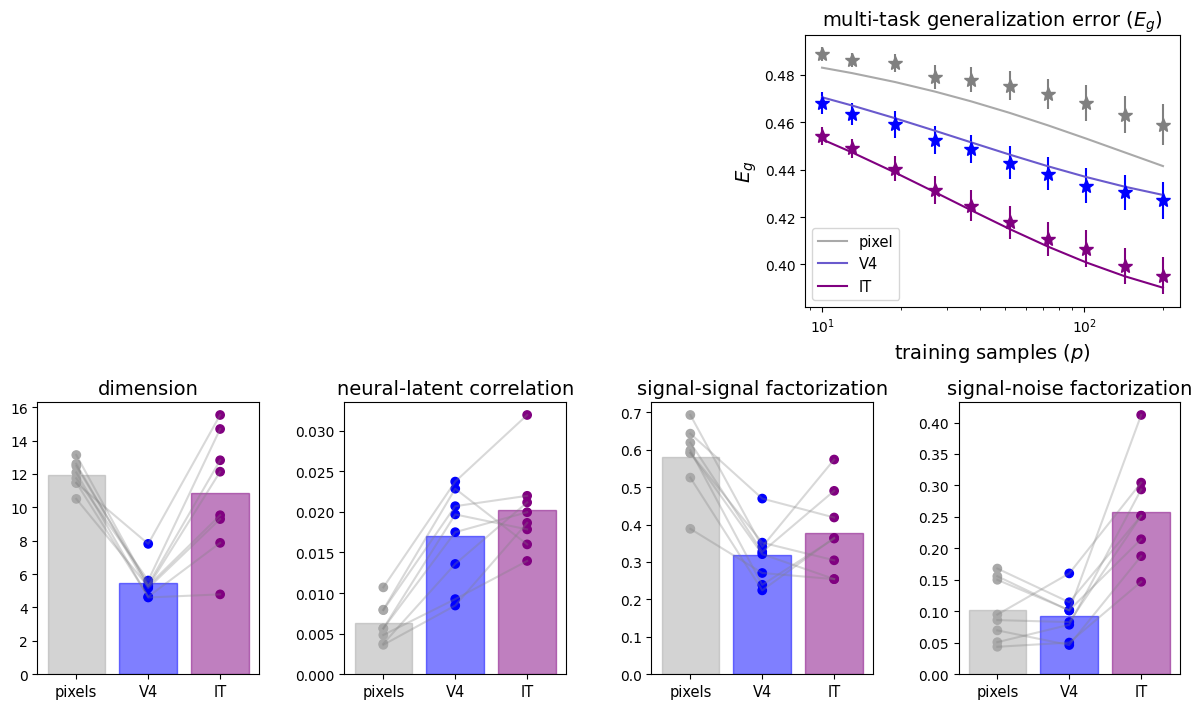

In [21]:
ratio = 9/15 
w = 12 
fig = plt.figure(figsize=(w,w*ratio)) 
fn = 14
gs = GridSpec(2,8)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']

# ax['a'] = fig.add_subplot(gs[0, :3])
ax['b'] = fig.add_subplot(gs[0,5:])

plot_res(ax['b'], emppixmed, thepixmed, empv4med, thev4med, 
         empITmed, theITmed, fn, 'Medium', colors)

ax['c'] = fig.add_subplot(gs[1,:2])
ax['d'] = fig.add_subplot(gs[1,2:4])
ax['e'] = fig.add_subplot(gs[1,4:6])
ax['f'] = fig.add_subplot(gs[1,6:])

axs = ['c', 'd', 'e', 'f']
axs = [ax[n] for n in axs] 
geoms_med = np.stack([geompixmed, geomv4med, geomITmed], axis=1)
# col_med=['tomato', 'tomato', 'tomato']
col_med = ['darkgrey', 'blue',  'purple']
w=0.8
plot_geom(axs, geoms_med, col_med, fn, 'med', offset = 0, width=w) 

# ax['e'].legend(fontsize=fn*2/3)
ax['b'].legend(fontsize=fn*3/4)

plt.tight_layout()
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/majaj.pdf', dpi=300, bbox_inches='tight') 
fig.savefig(figdir + '/f7_majaj.pdf', dpi=300, bbox_inches='tight') 

nclass =  8
[11.93367487  5.47019764 10.83208275]
[0.00625762 0.01696775 0.02018007]
[0.5811364  0.31796601 0.37787291]
[0.10239851 0.09202491 0.25787416]


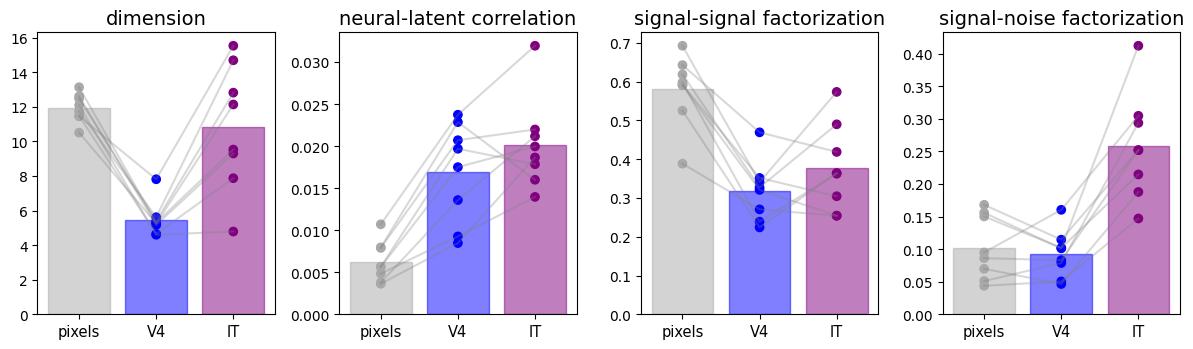

In [22]:
ratio = 9/15/2  
w = 12 
fig = plt.figure(figsize=(w,w*ratio)) 
fn = 14
gs = GridSpec(1,8)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']

# ax['a'] = fig.add_subplot(gs[0, :3])

# plot_res(ax['b'], emppixmed, thepixmed, empv4med, thev4med, 
#          empITmed, theITmed, fn, 'Medium', colors)

ax['c'] = fig.add_subplot(gs[:2])
ax['d'] = fig.add_subplot(gs[2:4])
ax['e'] = fig.add_subplot(gs[4:6])
ax['f'] = fig.add_subplot(gs[6:])

axs = ['c', 'd', 'e', 'f']
axs = [ax[n] for n in axs] 
geoms_med = np.stack([geompixmed, geomv4med, geomITmed], axis=1)
# col_med=['tomato', 'tomato', 'tomato']
col_med = ['darkgrey', 'blue',  'purple']
w=0.8
plot_geom(axs, geoms_med, col_med, fn, 'med', offset = 0, width=w) 

# ax['e'].legend(fontsize=fn*2/3)

plt.tight_layout()
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/majaj.pdf', dpi=300, bbox_inches='tight') 
fig.savefig(figdir + '/f7_majaj_bottom_no_sig.pdf', dpi=300, bbox_inches='tight') 

In [23]:
def ttests(data, group_labels, dv_labels, alpha=0.01, correction='fdr_bh', alternative='two-sided'):
    """
    Pairwise t-tests between groups for each dependent variable (within-subject).

    Parameters:
        data: ndarray of shape (N, M, K)
        group_labels: list of M group names
        dv_labels: list of K variable names
        alpha: significance level
        correction: multiple testing correction method
        alternative: 'two-sided', 'greater', or 'less'

    Returns:
        DataFrame of pairwise results with adjusted p-values.
    """
    n_rat, n_areas, n_geom = data.shape
    results = []
    all_pvals = []

    for k in range(n_geom):
        for i in range(n_areas): 
            for j in range(n_areas): 
                if i < j: 
                    x = data[:, i, k]
                    y = data[:, j, k]
                    t_stat, p_val = ttest_rel(x, y, alternative=alternative)
                    results.append({
                        'Variable': dv_labels[k],
                        'Group1': group_labels[i],
                        'Group2': group_labels[j],
                        'Mean1': np.mean(x),
                        'Mean2': np.mean(y),
                        'T': t_stat,
                        'p_uncorrected': p_val
                    })
                    all_pvals.append(p_val)

    # Correct for multiple comparisons
    reject, p_adj, _, _ = multipletests(all_pvals, alpha=alpha, method=correction)
    for i, (padj, rej) in enumerate(zip(p_adj, reject)):
        results[i]['p_adjusted'] = padj
        results[i]['significant'] = rej

    return pd.DataFrame(results)

def get_sig_label(p):
    if p < 0.01 : return '**'
    else: return 'n.s.'

    
def add_significance_bars(ax, bar_positions, pval, y_values, h=0.0, text_offset=0.0, squish=0.):
    """
    Add significance bars and stars to a given axis.

    Parameters:
        ax: matplotlib Axes
        bar_positions: list of x positions for each bar (e.g., [0, 1, 2])
        comparisons: list of tuples (i, j, pval) where i and j are group indices
        y_values: list of bar tops (e.g., means + stds) to determine bar height
        h: height of the significance line above the bar
        text_offset: extra offset for text
    """
    x1, x2 = bar_positions[0] + squish, bar_positions[1] - squish
    y = max(y_values[0], y_values[1])
    y = y * (1.2 + 0.25 * h) # add some height 
    lab =  get_sig_label(pval)
    ax.plot([x1, x1, x2, x2], [y * 0.95, y, y,y * 0.95],# [y_values[0] * 1.1, y, y, y_values[1]*1.1], 
            color='black', linewidth=1.2)
    ax.text((x1 + x2) / 2, y * 1.0 ,lab, va='bottom',ha='center', 
            # ha='center', va='bottom', 
            fontsize=10)

In [24]:
area_labs=['pix', 'V4', 'IT']
dv_labels=['dimension', 'corr.', 'SSF', 'SNF']
pvs_raw = ttests(geoms_med, group_labels = area_labs, 
            dv_labels = dv_labels)
pvs = pvs_raw[['Variable', 'Group1', 'Group2', 'T', 'p_uncorrected', 'p_adjusted']]
names = {'Variable' : 'Measure',
    'Group1' : "Group 1", 
         'Group2' : "Group 2",
         "T" : 't', 
         'p_uncorrected' : '$p$', 
         'p_adjusted' : '$p$ (adj.)',
         }
pvs = pvs.rename(columns=names) 
pvs = pvs[list(names.values())]
pvs

,Measure,Group 1,Group 2,t,$p$,$p$ (adj.)
0,dimension,pix,V4,12.950429,0.000004,0.000046
1,dimension,pix,IT,0.790809,0.455009,0.496373
2,dimension,V4,IT,-5.171963,0.001292,0.001938
3,corr.,pix,V4,-7.489405,0.000139,0.000416
4,corr.,pix,IT,-9.227381,0.000036,0.000185
5,corr.,V4,IT,-1.599272,0.153793,0.205057
6,SSF,pix,V4,8.890924,0.000046,0.000185
7,SSF,pix,IT,7.134798,0.000188,0.000451
8,SSF,V4,IT,-1.442800,0.192289,0.230746
9,SNF,pix,V4,0.682026,0.517147,0.517147


In [25]:
def format_dataframe(df, sig_digits=3, sci_thresh=1e-3, sci_digits=1):
    '''format the numerical columns of a df so that it shows up nicely in overleaf. '''
    def format_number(x):
        if pd.isna(x):
            return x
        if abs(x) < sci_thresh and x != 0:
            return f"{x:.{sci_digits}e}"
        else:
            # Round to significant digits
            return f"{x:.{sig_digits}g}"
    
    formatted_df = df.copy()
    for col in formatted_df.select_dtypes(include=[np.number]).columns:
        formatted_df[col] = formatted_df[col].apply(format_number)
    return formatted_df

out = format_dataframe(pvs)
out.to_csv(outdir + '/majaj_stats.csv', index=False)
out

,Measure,Group 1,Group 2,t,$p$,$p$ (adj.)
0,dimension,pix,V4,13,3.8e-06,4.6e-05
1,dimension,pix,IT,0.791,0.455,0.496
2,dimension,V4,IT,-5.17,0.00129,0.00194
3,corr.,pix,V4,-7.49,1.4e-04,4.2e-04
4,corr.,pix,IT,-9.23,3.6e-05,1.8e-04
5,corr.,V4,IT,-1.6,0.154,0.205
6,SSF,pix,V4,8.89,4.6e-05,1.8e-04
7,SSF,pix,IT,7.13,1.9e-04,4.5e-04
8,SSF,V4,IT,-1.44,0.192,0.231
9,SNF,pix,V4,0.682,0.517,0.517


nclass =  8
[11.93367487  5.47019764 10.83208275]
[0.00625762 0.01696775 0.02018007]
[0.5811364  0.31796601 0.37787291]
[0.10239851 0.09202491 0.25787416]


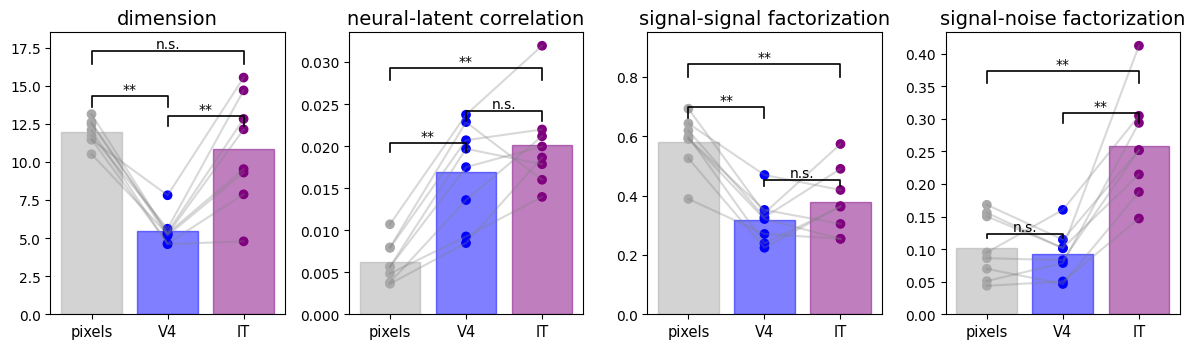

In [26]:
ratio = 9/15/2  
w = 12 
fig = plt.figure(figsize=(w,w*ratio)) 
fn = 14
gs = GridSpec(1,8)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']

ax['c'] = fig.add_subplot(gs[:2])
ax['d'] = fig.add_subplot(gs[2:4])
ax['e'] = fig.add_subplot(gs[4:6])
ax['f'] = fig.add_subplot(gs[6:])

axs = ['c', 'd', 'e', 'f']
axs = [ax[n] for n in axs] 
geoms_med = np.stack([geompixmed, geomv4med, geomITmed], axis=1)
# col_med=['tomato', 'tomato', 'tomato']
col_med = ['darkgrey', 'blue',  'purple']
w=0.8
plot_geom(axs, geoms_med, col_med, fn, 'med', offset = 0, width=w) 

axs[2].set_ylim([0,.95])
axs[0].set_ylim([0,18.5])

for i, ax in enumerate(axs): 
    for j, n1 in enumerate(area_labs): 
        for k, n2 in enumerate(area_labs): 
            if j < k : 
                x_positions = np.array([j,k])
                sdf = pvs_raw.loc[(pvs_raw.Variable == dv_labels[i]) & \
                                (pvs_raw.Group1 == n1) & \
                                (pvs_raw.Group2 == n2)]
                add_significance_bars(ax, 
                                      x_positions,
                                      sdf.p_adjusted.item(), 
                                      np.array([sdf.Mean1,sdf.Mean2]),
                                     h = 1 if j +  k == 2 else 0 , 
                                     )
            
            
    


plt.tight_layout()
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/majaj.pdf', dpi=300, bbox_inches='tight') 
fig.savefig(figdir + '/f7_majaj_bottom.pdf', dpi=300, bbox_inches='tight') 

8


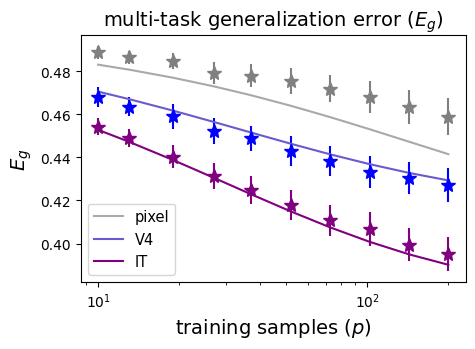

In [27]:
ratio = 9/15 /2
w = 12 
fig = plt.figure(figsize=(w,w*ratio)) 
fn = 14
gs = GridSpec(1,8)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']
ax['b'] = fig.add_subplot(gs[0,5:])
plot_res(ax['b'], emppixmed, thepixmed, empv4med, thev4med, 
         empITmed, theITmed, fn, 'Medium', colors)
# ax['e'].legend(fontsize=fn*2/3)
ax['b'].legend(fontsize=fn*3/4)

plt.tight_layout()
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/majaj.pdf', dpi=300, bbox_inches='tight') 
fig.savefig(figdir + '/f7_majaj_top.pdf', dpi=300, bbox_inches='tight') 

In [28]:
def plot_indv_geom(axs, geoms, colors, fn, vr, width=.5, k=.3): 
    names = ['dimension', 
             'neural-latent correlation', 
             'signal-signal factorization', 'signal-noise factorization'] 
    xticks = ['pixels', 'V4', 'IT']
    x = np.arange(len(xticks))
    nclass = geoms.shape[0]
    print('nclass = ', nclass) 
    offsets = np.linspace(-k, k, nclass)
    for i, ax in enumerate(axs): 
        for j, o in enumerate(offsets):
            bars = ax.bar(x+o, geoms[j, :,i], label=vr, width=width)
            for k, b in enumerate(bars):
                b.set_color(colors[k])
        ax.set_title(names[i], fontsize=fn)
        ax.set_xticks(x, xticks, fontsize=fn*3/4)
        
def plot_indv_errs(ax, emppix, thepix, empv4, thev4, empIT, theIT, fn, vr, colors, p_ind = -1):
    ''' 
    plot errors. assume shape n_class x n split x p for emp and n_class x p for theory
    '''
    ax.scatter(emppix[...,p_ind].mean(1), thepix[...,p_ind], color=colors[0], label='Pixels')
    ax.scatter(empv4[...,p_ind].mean(1), thev4[...,p_ind], color=colors[3], label='V4')
    ax.scatter(empIT[...,p_ind].mean(1), theIT[...,p_ind], color=colors[5], label='IT')
    ax.set_xlabel("empirical $E_g$", fontsize=fn)
    ax.set_ylabel("theoretical $E_g$", fontsize=fn)
    ax.set_title("match between theoretical and empirical $E_g$", fontsize=fn)
    ax.set_ylim(ax.get_xlim())
    
    
def label_axs(axss,fn,diff=-0.3):
    if type(axss) == dict: 
        for i, ax in enumerate(axss.values()):
            # label = '(' + string.ascii_lowercase[i] + ')'
            label = string.ascii_uppercase[i] 
            ax.text(diff, 1.15, label,  transform=ax.transAxes, fontsize=fn,  va='top', ha='left', weight='bold')
    else:
        for i, ax in enumerate(axss.flat):
            label = string.ascii_uppercase[i] 
            # label = '(' + string.ascii_lowercase[i] + ')'
            ax.text(diff, 1.15, label,  transform=ax.transAxes, fontsize=fn,  va='top', ha='left', weight='bold')

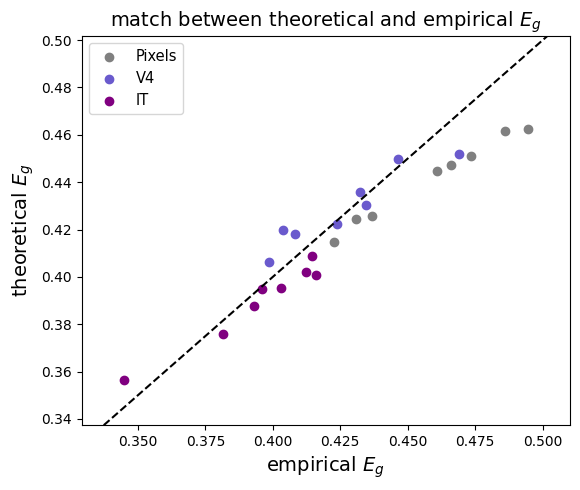

In [29]:
w=6
ratio = 5/6 
fn=14
fig, ax = plt.subplots(1,1,figsize=(w,ratio*w))

plot_indv_errs(ax, emppixmed, thepixmed, empv4med, thev4med, 
         empITmed, theITmed, fn, 'Medium', colors)

plt.tight_layout()
ax.legend(fontsize=fn*3/4)
ln = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
ax.plot(ln,ln,color='k',ls='--')
fig.savefig(figdir + '/sm_majaj_ind_err.pdf', dpi=300, bbox_inches='tight') 

nclass =  8


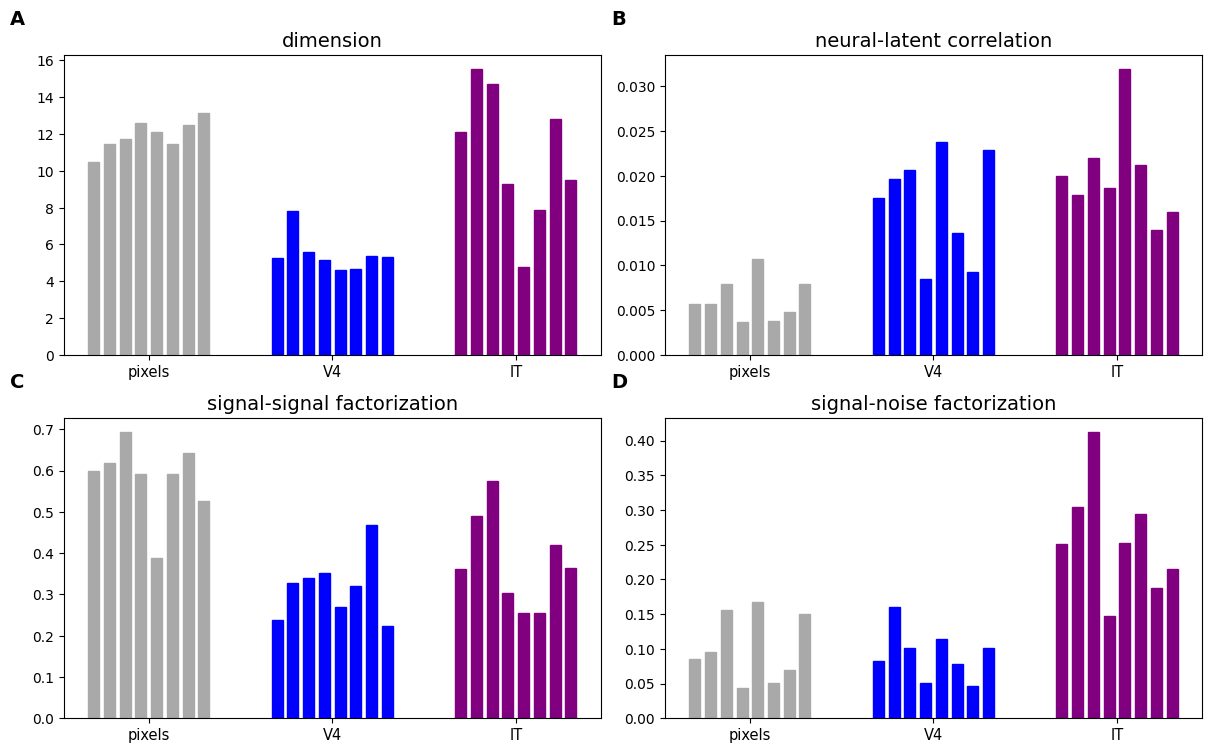

In [30]:
ratio = 2/(1 + np.sqrt(5))
w = 12 
fn =14 
fig, ax = plt.subplots(2,2,figsize=(w,ratio*w))
w=0.06
plot_indv_geom(ax.flat, geoms_med, col_med, fn, 'med', width=w) 
plt.tight_layout()
label_axs(ax,fn,diff=-0.1)
fig.savefig(figdir + '/sm_majaj_ind_geom.pdf', dpi=300, bbox_inches='tight') 

In [31]:
def plot_res_global(ax, emppix, thepix, empv4, thev4, empIT, theIT, fn, vr, colors, Ps=Psg):
    ax.errorbar(Ps, emppix.mean((0)), yerr=emppix.std((0)), 
                color=colors[0], **emp_kwargs)
    ax.plot(Ps, thepix,label='pixel',ls='-',color=colors[1])

    ax.errorbar(Ps, empv4.mean((0)), yerr=empv4.std(0), color=colors[2], **emp_kwargs)
    ax.plot(Ps, thev4,label='V4',ls='-',color=colors[3])

    ax.errorbar(Ps, empIT.mean((0)), yerr=empIT.std(0), color=colors[4],**emp_kwargs)
    ax.plot(Ps, theIT,label='IT',ls='-',color=colors[5])

    ax.set_xlabel("training samples ($p$)", fontsize=fn)
    ax.set_ylabel("$E_g$", fontsize=fn)
    ax.set_title("average generalization error ($E_g$)", fontsize=fn)

    ax.set_xscale('log')
    
def plot_geom_global(axs, geoms, colors, fn, vr, offset=0., width=1.): 
    names = ['dimension', 
             'neural-latent correlation', 
             'signal-signal factorization', 'signal-noise factorization'] 
    xticks = ['pixels', 'V4', 'IT']
    # for i, ax in enumerate(axs): 
    #     ax.plot(xticks, geoms[i],color=colors[i], label=vr)
    #     ax.set_title(names[i], fontsize=fn)
    #     ax.set_xticklabels(xticks, fontsize=fn*3/4)
    x = np.arange(len(xticks))
    n = geoms.shape[0]
    print('n = ', n) 
    for i, ax in enumerate(axs): 
        print(geoms[:,i].mean(0))
        bars=ax.bar(x+offset, geoms[...,i], label=vr, width=width)
        ax.set_title(names[i], fontsize=fn)
        ax.set_xticks(x, xticks, fontsize=fn*3/4)
        for k, b in enumerate(bars):
            b.set_color(colors[k])

n =  3
11.062182034966037
0.007496136535453277
0.3056043411265768
0.06152786617806364


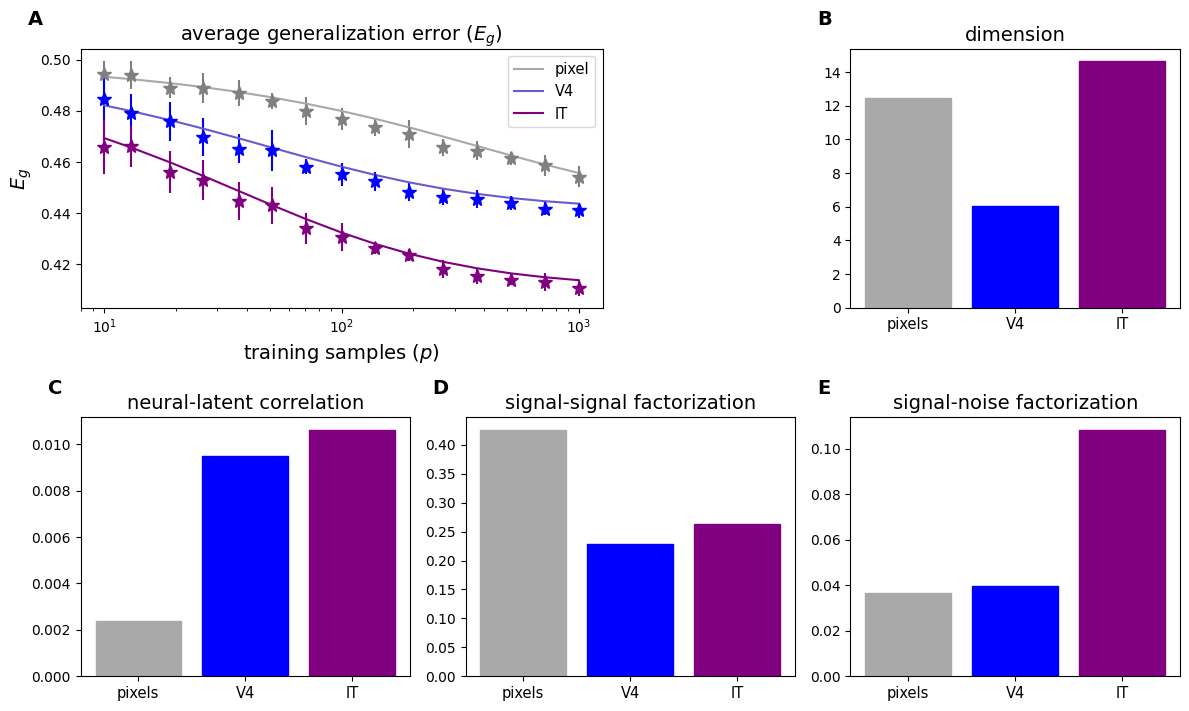

In [32]:
ratio = 9/15
w=12
fig = plt.figure(figsize=(w,ratio*w)) 
fn = 14
gs = GridSpec(2,6)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']

ax['b'] = fig.add_subplot(gs[0,:3])

plot_res_global(ax['b'], pemppixmed, pthepixmed, pempv4med, pthev4med, 
         pempITmed, ptheITmed, fn, 'Medium', colors)


ax['c'] = fig.add_subplot(gs[0,4:])
ax['d'] = fig.add_subplot(gs[1,:2])
ax['e'] = fig.add_subplot(gs[1,2:4])
ax['f'] = fig.add_subplot(gs[1,4:])

axs = ['c', 'd', 'e', 'f']
axs = [ax[n] for n in axs] 
# we can stack on the zero dim since there's no batch dim 
geoms_med = np.stack([pgeompixmed, pgeomv4med, pgeomITmed], axis=0)
# col_med = ['tomato', 'tomato', 'tomato']
col_med = ['darkgrey', 'blue',  'purple']

w=0.8
plot_geom_global(axs, geoms_med, col_med, fn, 'med', offset = 0, width=w) 

# ax['e'].legend(fontsize=fn*2/3)
ax['b'].legend(fontsize=fn*3/4)
label_axs(ax,fn,diff=-0.1)
plt.tight_layout()
fig.savefig(figdir + '/sm_majaj_global.pdf', dpi=300, bbox_inches='tight') 

## random projection results

8
nclass =  8
[9.38514564 5.47019764 9.33165428]
[0.00644328 0.01696775 0.02072996]
[0.5337192  0.31796601 0.35724781]
[0.0734761  0.09202491 0.22888197]


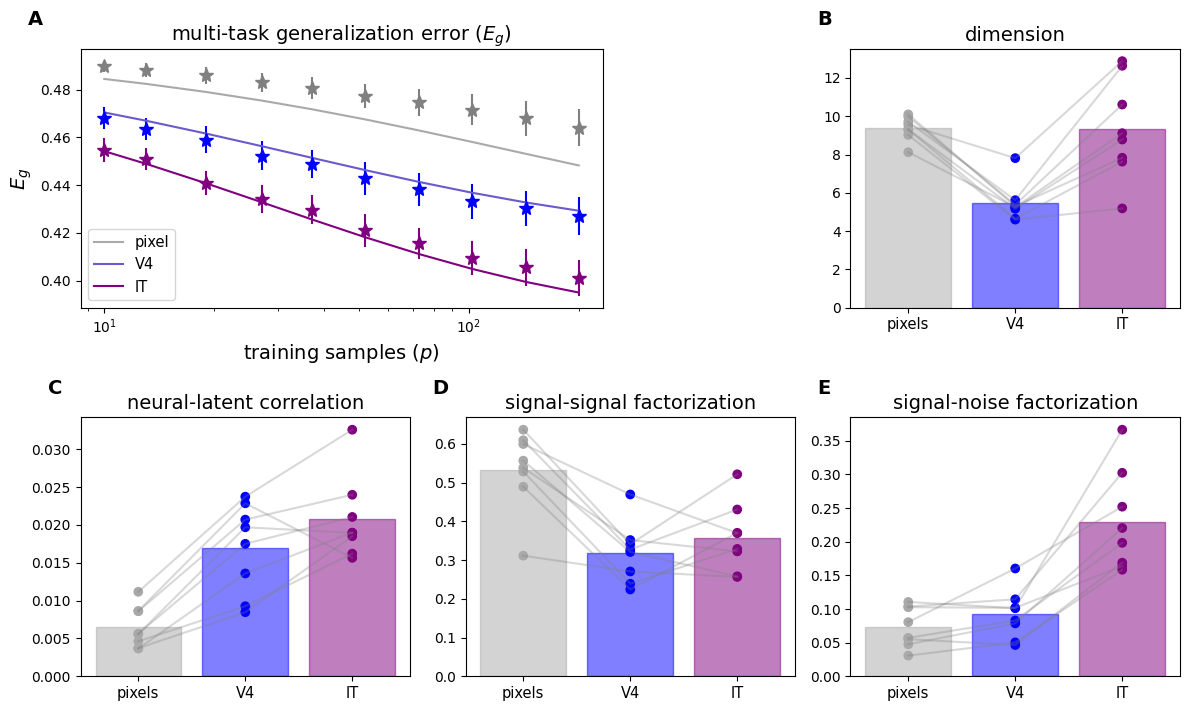

In [33]:
ratio = 9/15
w=12
fig = plt.figure(figsize=(w,ratio*w)) 
fn = 14
gs = GridSpec(2,6)
ax = {} 
emp_kwargs = {'marker' : '*', 'markersize' : 10, 'ls' : ''}
colors = ['grey', 'darkgrey', 'blue', 'slateblue', 'purple', 'purple']

ax['b'] = fig.add_subplot(gs[0,:3])

plot_res(ax['b'], emppixmedproj, thepixmedproj, empv4med, thev4med, 
         empITmedproj, theITmedproj, fn, 'Medium', colors)


ax['c'] = fig.add_subplot(gs[0,4:])
ax['d'] = fig.add_subplot(gs[1,:2])
ax['e'] = fig.add_subplot(gs[1,2:4])
ax['f'] = fig.add_subplot(gs[1,4:])

axs = ['c', 'd', 'e', 'f']
axs = [ax[n] for n in axs] 
geoms_med = np.stack([geompixmedproj, geomv4med, geomITmedproj], axis=1)


# col_med = ['tomato', 'tomato', 'tomato']
col_med = ['darkgrey', 'blue',  'purple']

w=0.8
plot_geom(axs, geoms_med, col_med, fn, 'med', offset = 0, width=w) 

# ax['e'].legend(fontsize=fn*2/3)
ax['b'].legend(fontsize=fn*3/4)
label_axs(ax,fn,diff=-0.1)
plt.tight_layout()
fig.savefig(figdir + '/sm_majaj_proj.pdf', dpi=300, bbox_inches='tight') 

## SVC results

In [34]:
import seaborn as sns

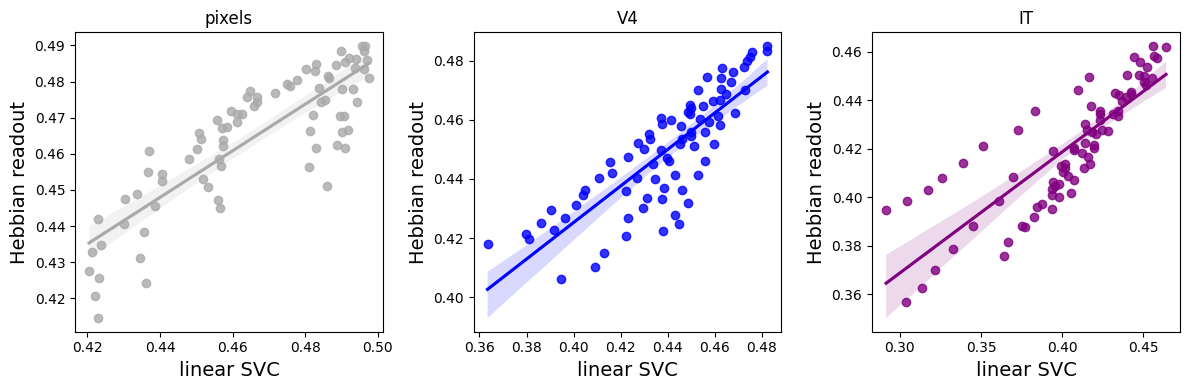

In [35]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
fn=14
col_med = ['darkgrey', 'blue',  'purple']
vals = [[svcpixmed.mean(1).reshape(-1),  thepixmed.reshape(-1)],
        [svcv4med.mean(1).reshape(-1),  thev4med.reshape(-1)], 
        [svcITmed.mean(1).reshape(-1), theITmed.reshape(-1)]]
# np=5
# vals = [[svcpixmed.mean(1)[:, np],  thepixmed[:, np]],
#         [svcv4med.mean(1)[:, np],  thev4med[:, np]], 
#         [svcITmed.mean(1)[:, np], theITmed[:,np]]]
names = ['pixels', 'V4', 'IT'] 
for i, ax in enumerate(axs):
    svc, the = vals[i] 
    # ax.scatter(svc, the, color=col_med[i])
    sns.regplot(x=svc, y=the, ax=ax, color=col_med[i])
    ax.set_title(names[i])
    ax.set_xlabel("linear SVC", fontsize=fn) 
    ax.set_ylabel("Hebbian readout", fontsize=fn) 
plt.tight_layout() 

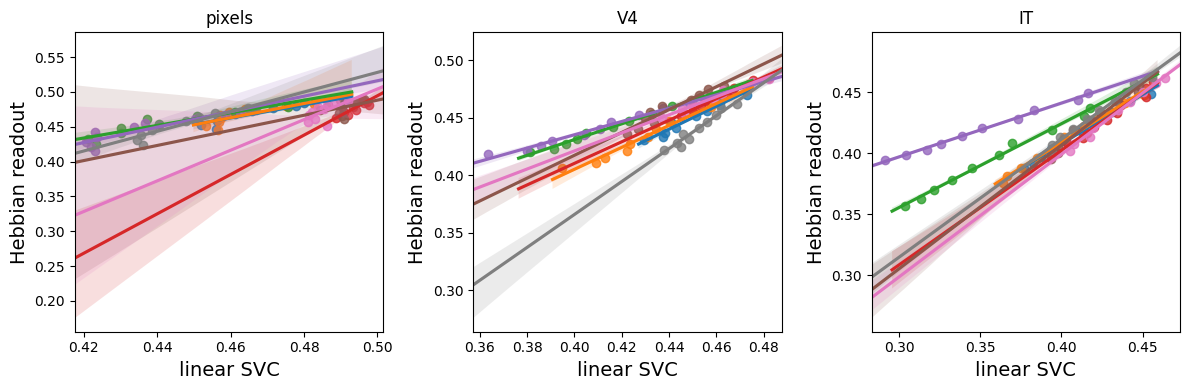

In [36]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
fn=14
col_med = ['darkgrey', 'blue',  'purple']
vals = [[svcpixmed.mean(1).reshape(-1),  thepixmed.reshape(-1)],
        [svcv4med.mean(1).reshape(-1),  thev4med.reshape(-1)], 
        [svcITmed.mean(1).reshape(-1), theITmed.reshape(-1)]]
# np=5
names = ['pixels', 'V4', 'IT'] 
NP  = 10
for i, ax in enumerate(axs):
    for cls in range(8) :
        vals = [[svcpixmed.mean(1)[cls],  thepixmed[cls]],
                    [svcv4med.mean(1)[cls],  thev4med[cls]], 
                    [svcITmed.mean(1)[cls], theITmed[cls]]]
        svc, the = vals[i] 
    # ax.scatter(svc, the, color=col_med[i])
        sns.regplot(x=svc, y=the, ax=ax,truncate=False)
    ax.set_title(names[i])
    ax.set_xlabel("linear SVC", fontsize=fn) 
    ax.set_ylabel("Hebbian readout", fontsize=fn) 
plt.tight_layout() 